In [2]:
# https://arxiv.org/abs/1610.02415

# https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html
print("Code is running!")
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.distributed as dist

import torch_geometric
import torch_geometric.nn as gnn

from torch_geometric.datasets import QM9
import GCL.augmentors
import GCL.augmentors as A
import edge_removing as A_alternate
from torch_geometric.nn import GCNConv

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, mean_squared_error, r2_score
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression, LinearRegression
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from rdkit.Chem import PeriodicTable
from rdkit import Chem
from xenonpy.datatools import preset
from xenonpy.descriptor import Compositions
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from matplotlib.pylab import plt
from numpy import arange
import math
import timeit
import os
from datetime import datetime

import ipynb.fs.full.XenonPy_transformation as XPy



Code is running!


In [3]:
#the following are needed to use PyTorch Lightning
from functools import partial
from typing import Sequence, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as VisionF
from pytorch_lightning import Callback, LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from torch import Tensor
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import CIFAR10
from torchvision.models.resnet import resnet18
from torchvision.utils import make_grid


In [4]:
#record start time
t_0 = timeit.default_timer()
# call function

In [5]:
#QM9 dataset list of input features and list of target features
dataset = "QM9"

#list of input features in QM9 dataset
x_index = {0: 'H atom?',
1: 'C atom?',
2: 'N atom?',
3: 'O atom?',
4: 'F atom?',
5: 'atomic_number',
6: 'aromatic',
7: 'sp1',
8: 'sp2',
9: 'sp3',
10: 'num_hs'}
x_index_list = ['H atom?', 
                'C atom?', 
                'N atom?', 
                'O atom?', 
                'F atom?', 
                'atomic_number', 'aromatic', 
                'sp1',
                'sp2',
                'sp3',
                'num_hs']


#list of target features in QM9 dataset
qm9_index = {0: 'Dipole_moment',
1: 'Isotropic_polarizability',
2: 'HOMO',
3: 'LUMO',
4: 'HOMO_LUMO_gap',
5: 'Electronic_spatial_extent',
6: 'Zero_point_vibrational_energy',
7: 'Internal_energy_at_0K',
8: 'Internal_energy_at_298.15K',
9: 'Enthalpy_at_298.15K',
10: 'Free_energy_at_298.15K',
11: 'Heat_capacity_at_298.15K',
12: 'Atomization_energy_at_0K',
13: 'Atomization_energy_at_298.15K',
14: 'Atomization_enthalpy_at_298.15K',
15: 'Atomization_free_energy_at_298.15K',
16: 'Rotational_constant_A',
17: 'Rotational_constant_B',
18: 'Rotational_constant_C'}

In [6]:
#parameters for GCL methods

tr_batch_size = 1000
val_batch_size = 200
test_batch_size = 100
tr_ratio = 0.9
val_ratio = 0.09
test_ratio = 0.01
num_workers = 2
shuffle = True
qm9_index_list = ['Dipole_moment', 
                  'Isotropic_polarizability',
                  'Highest_occupied_molecular_orbital_energy',
                  'Lowest_unoccupied_molecular_orbital_energy',
                  'Gap_between_previous_2',
                  'Electronic_spatial_extent',
                  'Zero_point_vibrational_energy',
                  'Internal_energy_at_0K',
                  'Internal_energy_at_298.15K',
                  'Enthalpy_at_298.15K',
                  'Free_energy_at_298.15K',
                  'Heat_capacity_at_298.15K',
                  'Atomization_energy_at_0K',
                  'Atomization_energy_at_298.15K',
                  'Atomization_enthalpy_at_298.15K',
                  'Atomization_free_energy_at_298.15K',
                  'Rotational_constant_A',
                  'Rotational_constant_B',
                  'Rotational_constant_C']

parameters = {}
parameters['tr_batch_size'] = tr_batch_size

parameters_used = {}
parameters_used['dataset'] = dataset
parameters_used['tr_batch_size'] = tr_batch_size
parameters_used['val_batch_size'] = val_batch_size
parameters_used['test_batch_size'] = test_batch_size
parameters_used['tr_ratio'] = tr_ratio
parameters_used['val_ratio'] = val_ratio
parameters_used['test_ratio'] = test_ratio
parameters_used['num_workers'] = num_workers
parameters_used['shuffle'] = shuffle
parameters_used['target_properties'] = qm9_index_list

#vicreg loss function parameters
sim_coeff = 25
std_coeff = 25
cov_coeff = 1

#list of training augmentations
tr_augmentations = [#A.RWSampling(num_seeds=1000, walk_length=10),
                      A.NodeDropping(pn=0.1),
                      A.FeatureMasking(pf=0.1),
                      A_alternate.EdgeRemoving(pe=0.1)]

#list of validation augmentations
val_augmentations = []

#list of test augmentations
test_augmentations = []

#number of choices for augmentations for training, validation, and test sets, respectively
tr_num_choices = 1
val_num_choices = 0
test_num_choices = 0

#Adam parameters
Adam_learning_rate = 0.002
Adam_weight_decay = 5e-4
adam = {'lr': Adam_learning_rate, 
        'weight_decay': Adam_weight_decay
       }

#dictionary of optimizers used
optimizers = {}
optimizers['adam'] = adam



#dictionary of loss functions used
loss_functions_used = {}

vicreg = {'sim_coeff': sim_coeff,
          'std_coeff': std_coeff,
          'cov_coeff': cov_coeff
         }

loss_functions_used['vicreg'] = vicreg

augmentations_used = {}
augmentations_used['tr_augmentations'] = tr_augmentations
augmentations_used['val_augmentations'] = val_augmentations
augmentations_used['test_augmentations'] = test_augmentations
augmentations_used['tr_num_choices'] = tr_num_choices
augmentations_used['val_num_choices'] = val_num_choices
augmentations_used['test_num_choices'] = test_num_choices


periodic_table = Chem.GetPeriodicTable()

In [7]:
#parameters for downstream ML models

#dictionary of parameters used for downstream Linear Models
lm_parameters = {'default': 'used default for all parameters'}

#dictionary of parameters used for downstream Random Forest models
rf_parameters = {'n_estimators': 10, 
                 'max_depth': 10 }

#dictionary of parameters used for downstream LightGBM models
lgbm_params = {'boosting_type': 'gbdt',
               'objective': 'regression',
               'metric': {'l2', 'l1'},
               'num_leaves': 31,
               'learning_rate': 0.05,
               'force_col_wise': 'true',
               'feature_fraction': 0.9,
               'bagging_fraction': 0.8,
               'bagging_freq': 5,
               'verbose': -1
            }
lgbm_parameters = {'params': lgbm_params,
            'num_boost_round': 20,
            'callbacks': [lgb.early_stopping(stopping_rounds=5)]
                  }


downstream_model_parameters = {}
downstream_model_parameters['lm_parameters'] = lm_parameters
downstream_model_parameters['rf_parameters'] = rf_parameters
downstream_model_parameters['lgbm_parameters'] = lgbm_parameters



parameters_used['loss_functions_used'] = loss_functions_used
parameters_used['augmentations_used'] = augmentations_used
parameters_used['optimizer'] = optimizers
parameters_used['adam_learning_rate'] = Adam_learning_rate
parameters_used['adam_weight_decay'] = Adam_weight_decay
parameters_used['downstream_model_parameters'] = downstream_model_parameters



In [8]:
#load the dataset through tr, val, and test data loaders

whole_dataset = QM9(root = 'data/')

n = whole_dataset.len()
tr_n = math.floor(tr_ratio*n) # Number of QM9 to use as training data
val_n = math.floor(val_ratio*n)


all_inds = range(n)
tr_inds, val_inds = train_test_split(all_inds, train_size = tr_n, random_state = 24)
val_test_inds = range(n - tr_n)
val_inds, test_inds = train_test_split(val_test_inds, train_size = val_n, random_state = 24)


print("Size of training set: ", len(tr_inds))
print("Size of validation set: ", len(val_inds))
print("Size of test set: ", len(test_inds))


train_sampler = torch.utils.data.SubsetRandomSampler(tr_inds)
val_sampler = torch.utils.data.SubsetRandomSampler(val_inds)
test_sampler = torch.utils.data.SubsetRandomSampler(test_inds)


# We need to make a train and validation set since QM9 does not provide them
train_set = torch.utils.data.Subset(whole_dataset, tr_inds)
val_set = torch.utils.data.Subset(whole_dataset, val_inds)
test_set = torch.utils.data.Subset(whole_dataset, test_inds)

train_loader = torch_geometric.loader.DataLoader(train_set, batch_size = tr_batch_size,
                                                shuffle = shuffle, num_workers = num_workers)
                                                #sampler = train_sampler)

val_loader = torch_geometric.loader.DataLoader(val_set, batch_size=val_batch_size,
                                            shuffle=shuffle, num_workers=num_workers, drop_last=True)
                                              #sampler = val_sampler)
test_loader = torch_geometric.loader.DataLoader(test_set, batch_size=test_batch_size,
                                            shuffle=shuffle, num_workers=num_workers)
                                              #sampler = val_sampler)

Size of training set:  117747
Size of validation set:  11774
Size of test set:  1310


In [9]:
def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

def VicRegLoss(x, y):
    # https://github.com/facebookresearch/vicreg/blob/4e12602fd495af83efd1631fbe82523e6db092e0/main_vicreg.py#L184
    # x, y are output of projector(backbone(x and y))
    repr_loss = F.mse_loss(x, y)

    x = x - x.mean(dim=0)
    y = y - y.mean(dim=0)

    std_x = torch.sqrt(x.var(dim=0) + 0.0001)
    std_y = torch.sqrt(y.var(dim=0) + 0.0001)
    std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

    cov_x = (x.T @ x) / (tr_batch_size - 1)
    cov_y = (y.T @ y) / (tr_batch_size - 1)
    cov_loss = off_diagonal(cov_x).pow_(2).sum().div(
        x.shape[1]
    ) + off_diagonal(cov_y).pow_(2).sum().div(x.shape[1])
    
    # self.num_features -> rep_dim?
    loss = (
        sim_coeff * repr_loss
        + std_coeff * std_loss
        + cov_coeff * cov_loss
    )
    return loss




In [10]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.rep_dim = 128
        self.emb_dim = 256
        
        # Data under graph
        self.conv1 = GCNConv(whole_dataset.num_node_features, self.rep_dim // 2)
        self.bn1 = nn.BatchNorm1d(self.rep_dim // 2)
        self.a1 = nn.LeakyReLU(0.02)
        
        self.conv2 = GCNConv(self.rep_dim // 2, self.rep_dim) # To Rep Space
        self.bn2 = nn.BatchNorm1d(self.rep_dim)
        
        # Projection to representation
        self.mpool1 = gnn.global_mean_pool
        #self.fc1 = nn.Linear(self.rep_dim, self.rep_dim)
        
        # Graph 2
        self.conv3 = GCNConv(self.rep_dim, self.rep_dim * 2) # To Emb Space
        self.bn3 = nn.BatchNorm1d(self.rep_dim * 2)
        
        # Projection to embedding
        self.mpool2 = gnn.global_mean_pool
        self.fc2 = nn.Linear(self.emb_dim, self.emb_dim) # Linear to rep?
            #might want to get rid of this
        
    def forward(self, data, binds):
        x = data[0].float().to(device)
        edge_index = data[1].to(device)
        
        # Input graph to GConv
        x = self.conv1(x, edge_index)
        x = self.a1(self.bn1(x))
        x = F.dropout(x, training=self.training)
        
        x = self.bn2(self.conv2(x, edge_index))
        
        # GConv outputs projected to representation space
        #print('before pool: ', x.shape)
        x_rep = self.mpool1(x, binds)
        #print('pooled: ', x_rep.shape)
        
        #x_rep = self.fc1(x_rep)
        #print('projected: ', x_rep.shape, 'gconv', x.shape)
        
        x_emb = self.bn3(self.conv3(x, edge_index))
        #print('x emb after conv3', x_emb.shape)
        x_emb = self.mpool2(x_emb, binds)
        #print('after pool', x_emb.shape)
        x_emb = self.fc2(x_emb)
        #print('after fc2', x_emb.shape)
        
        return x_rep, x_emb

In [11]:
def atoms_dictionary(atomic_num):
    atomic_symbol = periodic_table.GetElementSymbol(atomic_num)
    return atomic_symbol

In [12]:
def get_mol_dict(batch): #Give a chemical formula

        graph_chem_formulae_dictionaries = pd.DataFrame()
        if not graph_chem_formulae_dictionaries.empty:
            graph_chem_formulae_dictionaries.drop(columns = 'formula')

        node_to_graph_indicator = pd.DataFrame(batch.batch).astype("int")
        node = pd.DataFrame(batch.x).astype("int")
        mol_list = []
        j = 0
        mol_dict = {}
        for i in range(len(batch.z)):
                #get a dictionary for each graph that contains chemical formula
                    #format for use for XenonPy
            if j == int(node_to_graph_indicator.iloc[i]):
                    #add this ith atom to to the dictionary for the jth graph
                    #atoms_dictionary(atomic_num)
                    #call function to add element to molecular dictionary
                element = atoms_dictionary(int(node[5].iloc[i]))
                if element in mol_dict:
                    mol_dict[element] = mol_dict[element] + 1
                else:
                    mol_dict[element] = 1
            else: #need to move to next graph
                    #Insert these dictionaries to each row in the df
                mol_list.append(mol_dict)
                mol_dict = {}
                element = atoms_dictionary(int(node[5].iloc[i]))
                j += 1

        mol_list.append(mol_dict) #need to append the last dict
        graph_chem_formulae_dictionaries.insert(0, 'formula', mol_list)
        for i in range(len(batch.y) - 1):
            if mol_list[i]:
                pass
            else:
                print("Empty!!", " location: ", i)

        return graph_chem_formulae_dictionaries

In [13]:
def plot_loss_curves(loss_per_epoch, val_loss):
    train_values = loss_per_epoch
    val_values = val_loss
 
    # Generate a sequence of integers to represent the epoch numbers
    epochs = range(0, len(loss_per_epoch))
 
    # Plot and label the training and validation loss values
    plt.plot(epochs, train_values, label='Training Loss')
    plt.plot(epochs, val_values, label='Validation Loss')
 
    # Add in a title and axes labels
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
 
    # Set the tick locations

    plt.xticks(arange(0, len(loss_per_epoch), max(math.floor(len(loss_per_epoch)/10), 1)))
 
    # Display the plot
    plt.legend(loc='best')
    plt.show()

In [14]:
device = 'cuda'
model = GCN().to(device)

In [15]:
#augmentations and optimizers initializations
tr_aug = A.RandomChoice(tr_augmentations, #edge_adj was deprecated, so need to use edge_ something instead
                      num_choices=tr_num_choices)
#should do many other types of augmentations
    #train models on all but one augmentations and see which work best
        #ablation study!
val_aug = A.RandomChoice(val_augmentations, num_choices = val_num_choices)
test_aug = A.RandomChoice(test_augmentations, num_choices = test_num_choices)
optimizer = torch.optim.Adam(model.parameters(), lr=Adam_learning_rate, weight_decay=Adam_weight_decay)



In [16]:

n_epochs = 1
epoch_loss = []
val_epoch_loss = []
print("Starting Training!")
for epoch in range(0,n_epochs+1):
    #print("epoch: ", epoch)
    epoch_losses = []
    for batch in train_loader:
        optimizer.zero_grad()

        batch_inds = batch.batch.to(device)
      
        # batch of graphs has edge attribs, node attribs - (n_nodes, n_features+1) -> concat (n_nodes, attrib1)

        batch.x = batch.x.float()#.to(device)
        #batch.edge_index = batch.edge_index.to(device)

        # Barlow - get 2 random views of batch
        b1 = tr_aug(batch.x, batch.edge_index, batch.edge_attr)
        b2 = tr_aug(batch.x, batch.edge_index, batch.edge_attr)

        # Embed each batch (ignoring representations)
        r1, e1 = model(b1, batch_inds)
        r2, e2 = model(b2, batch_inds)

        loss = VicRegLoss(e1, e2)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.data.item())
        
    epoch_loss.append(sum(epoch_losses) / len(epoch_losses))
    print('epoch', epoch,'train loss:', sum(epoch_losses) / len(epoch_losses))

    
    val_loss = 0
    model.eval()
    
    # VicReg Validation Loss
    val_epoch_losses = []
    for batch in val_loader:
        with torch.no_grad():
            # VicReg validation loss
            b1 = val_aug(batch.x, batch.edge_index, batch.edge_attr)
            b2 = val_aug(batch.x, batch.edge_index, batch.edge_attr)
            r1, e1 = model(b1, batch.batch.to(device))
            r2, e2 = model(b2, batch.batch.to(device))
                
            val_loss = VicRegLoss(e1, e2)
            val_epoch_losses.append(val_loss.data.item())
            

    val_epoch_loss.append(sum(val_epoch_losses) / len(val_epoch_losses))    
    print('epoch', epoch,'val loss:', sum(val_epoch_losses) / len(val_epoch_losses))

    
print("Done training GCL model!")        
               

Starting Training!
epoch 0 train loss: 19.601951502137265
epoch 0 val loss: 16.236791742259058
epoch 1 train loss: 25.890916016142246
epoch 1 val loss: 17.477760545138654
Done training GCL model!


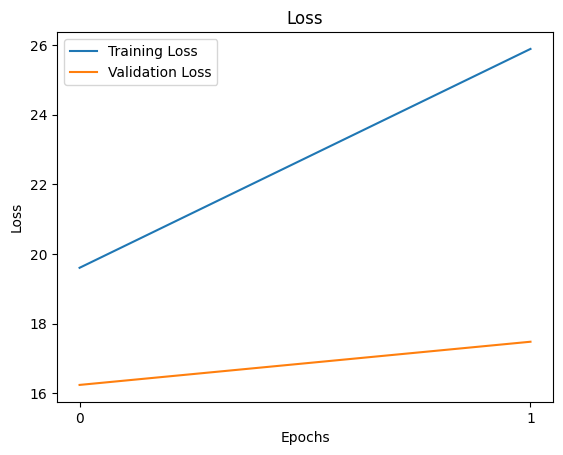

In [17]:
#plot train-val loss curves
plot_loss_curves(epoch_loss, val_epoch_loss)

In [18]:
#function to embed data
def get_embeddings(data_loader, model, aug):
    x = pd.DataFrame()
    x_no_aug = pd.DataFrame()
    y = pd.DataFrame()
    y_no_aug = pd.DataFrame()
    graph_chem_formulae_dictionaries = pd.DataFrame()
    for batch in data_loader: # take entire train set
        x_tabular_no_aug = pd.DataFrame(batch.x).astype("float")
        x_no_aug = pd.concat([x_no_aug, x_tabular_no_aug], ignore_index = True)
        y_tabular_no_aug = pd.DataFrame(batch.y).astype("float")
        y_no_aug = pd.concat([y_no_aug, y_tabular_no_aug], ignore_index = True)
        graph_chem_formulae_dictionaries = pd.concat([graph_chem_formulae_dictionaries, get_mol_dict(batch)], ignore_index = True)
        with torch.no_grad():
            # Embed training set under model
            rep, _ = model(aug(batch.x, batch.edge_index, batch.edge_attr), batch.batch.to(device))
            if torch.cuda.is_available():
                rep = rep.to("cpu")
            rep_tabular = pd.DataFrame(rep.numpy())
            x = pd.concat([x, rep_tabular], ignore_index = True)
            y_tabular = pd.DataFrame(batch.y).astype("float")
            y = pd.concat([y, y_tabular], ignore_index = True)
    
    return x, y, graph_chem_formulae_dictionaries, model

In [19]:
def get_XenonPy_transform(tr_graph_chem_dict, val_graph_chem_dict, test_graph_chem_dict, col_name):
    #returns XenonPy transformations for tr, val, and test sets
    print("XenonPy transformation starting for training set!")
    xenonpy_obj = XPy.XenonPy_transformation(tr_graph_chem_dict, col_name)
    tr_df_XenonPy = xenonpy_obj.XenonPy_transform()
    print("Done with training set!")
    print("XenonPy transformation starting for validation set!")
    xenonpy_obj = XPy.XenonPy_transformation(val_graph_chem_dict, col_name)
    val_df_XenonPy = xenonpy_obj.XenonPy_transform()
    print("Done with validation set!")
    print("XenonPy transformation starting for test set!")
    xenonpy_obj = XPy.XenonPy_transformation(test_graph_chem_dict, col_name)
    test_df_XenonPy = xenonpy_obj.XenonPy_transform()
    print("Done with test set!!!!")
    
    return tr_df_XenonPy, val_df_XenonPy, test_df_XenonPy



In [20]:
def save_xenonpy_transformation(tr_df, val_df, test_df, dataset_name): #saves xenonpy transformation to folder
    #only do this once per database!!
    #filename should be the name of the database
    parent_dir = '/home/ewvertina/Molecular_modelling'
    new_folder = dataset_name
    path = os.path.join(parent_dir, new_folder)
    os.mkdir(path)
    tr_path = path + '/xenon_tr.csv'
    val_path = path + '/xenon_val.csv'
    test_path = path + '/xenon_test.csv'
    tr_df.to_csv(tr_path)  
    val_df.to_csv(val_path)
    test_df.to_csv(test_path)
    return print("XenonPy transformations saved!")

In [21]:
#get embeddings for training set
x_tr, y_tr, tr_graph_chem_formulae_dictionaries, model = get_embeddings(train_loader, model, tr_aug)


In [22]:
#get embeddings for validation set
x_val, y_val, val_graph_chem_formulae_dictionaries, model = get_embeddings(val_loader, model, val_aug)


In [23]:
#get embeddings for test set
x_test, y_test, test_graph_chem_formulae_dictionaries, model = get_embeddings(test_loader, model, test_aug)


In [24]:
## transforms tr, val, and test sets with XenonPy and saves to local system
#col_name = 'formula'
#tr_df_XenonPy, val_df_XenonPy, test_df_XenonPy = get_XenonPy_transform(tr_graph_chem_formulae_dictionaries, val_graph_chem_formulae_dictionaries, test_graph_chem_formulae_dictionaries, col_name)                    
#save_xenonpy_transformation(tr_df_XenonPy, val_df_XenonPy, test_df_XenonPy, dataset)

In [75]:
def lm_models(x_train, x_test, y_train, y_test, target_feature, list_target_features):
    lm = LinearRegression().fit(x_train.values, y_train[target_feature].values)
    lm_yhat = lm.predict(x_test.values)
    lm_score = round(mean_squared_error(y_test[target_feature].values, lm_yhat), 2)
    print("Linear Regression Model MSE for ", target_feature, ": ", lm_score)
    r2 = round(r2_score(y_test[target_feature].values, lm_yhat), 2)
    print("R^2 score for linear model: ", r2)
    
    return lm_score, r2

In [76]:
def rf_models(x_train, x_test, y_train, y_test, target_feature, params, list_target_features):
    rf = RandomForestRegressor(n_estimators=params['n_estimators'], max_depth=params['max_depth'])
    rf.fit(x_train, y_train[target_feature])
    rf_yhat = rf.predict(x_test)
    rf_score = round(mean_squared_error(y_test[target_feature], rf_yhat), 2)
    print("RF Model Mean-Squared-Error for ", target_feature, ": ", rf_score)

    return rf_score


In [77]:
def lgbm_models(x_train, x_test, y_train, y_test, target_feature, params, list_target_features):
    lgb_train = lgb.Dataset(x_train.values, y_train[target_feature].values, params={'verbose': -1})
    lgb_eval = lgb.Dataset(x_test.values, y_test[target_feature].values, reference=lgb_train, params={'verbose': -1})
    gbm = lgb.train(params['params'],
                    lgb_train,
                    num_boost_round=params['num_boost_round'],
                    valid_sets=lgb_eval,
                    callbacks=params['callbacks'])
    lgb_yhat = gbm.predict(x_test.values, num_iteration=gbm.best_iteration)
    lgb_score = round(mean_squared_error(y_test[target_feature].values, lgb_yhat), 2)
    print("LightGBM Model MSE for ", target_feature, ": ", lgb_score)

    return lgb_score


In [78]:
#a function to run linear models
def linear_models(x_train, x_test, y_train, y_test, list_target_features, rf_parameters, lgbm_params):
    # For each task in QM9
    results_list = [] #list of dictionaries, where each dictionary contains the results from that model for each feature
    lgb_results_dict = {}
    rf_results_dict = {}
    lm_results_dict = {}
    model_info = {}
    means_vector = y_train.mean(axis = 0)
    rep_means_vectors = means_vector.repeat(x_train.shape[0]) #create a vector where each entry is the mean

    for (_, target_feature) in enumerate(y_train):
        print("target_feature: ", target_feature)
        if target_feature == 'index':
            pass
        else:
            ## Fit a model on model representation of train set:
            ##Need to drop missing values for linear models, since they do not allow these
            lm_score, r2 = lm_models(x_train, x_test, y_train, y_test, target_feature, list_target_features,)
            lm_results_dict["LM_" + target_feature] = [lm_score, r2]

            #Fit Random Forest models here:
            #rf_score = rf_models(x_train, x_test, y_train, y_test, target_feature, rf_parameters, list_target_features)
            #rf_results_dict["RF_" + qm9_index_list[target_feature]] = rf_score


            #Fit LightGBM models here (LightGBM is supposedly better than XGBoost):
            lgb_score = lgbm_models(x_train, x_test, y_train, y_test, target_feature, lgbm_params, list_target_features)
            lgb_results_dict["Light_GBM_" + target_feature] = lgb_score



            #baseline is a model that always outputs the mean of the training sample        
            rep_means_vectors = means_vector[target_feature].repeat(x_test.shape[0])
            baseline = round(mean_squared_error(y_test[target_feature].values, rep_means_vectors), 2)
            print("Baseline MSE for ", target_feature, ": ", baseline)

        

        
    results_list.append(lm_results_dict) #append Linear Model results dictionary to results list    
    results_list.append(lgb_results_dict) #append Light GBM results dictionary to results list
    #results_list.append(rf_results_dict) #append Random Forest results dictionary to results list
    
    
    return results_list, model_info
        
        
        

In [29]:
#need to make sure that I am getting the correct graphs for y's

In [30]:
#join XenonPy transformations with x_tr and x_val
#need to access file from saved location
#x_tr.join(tr_df_XenonPy)
#x_val.join(val_df_XenonPy)

In [31]:
#qm9_index

In [32]:
def qm9_preprocessing(x_df, y_df, qm9_index):
    #need to drop the two rows with extremely large Rotational Constant A
    y_df.rename(columns=qm9_index, inplace=True)
    indexes = y_df.index[(y_df["Rotational_constant_A"] > 100000)]
    y_df.drop(y_df.index[indexes], axis=0, inplace=True)
    x_df.drop(labels=indexes, axis=0, inplace=True)
    y_df = y_df.reset_index()
    x_df = x_df.reset_index()
    return x_df, y_df

In [33]:
x_tr, y_tr = qm9_preprocessing( x_tr, y_tr, qm9_index)

In [34]:
x_val, y_val = qm9_preprocessing(x_val, y_val, qm9_index)

In [35]:
x_test, y_test = qm9_preprocessing(x_test, y_test, qm9_index)

In [36]:
#x_tr = x_tr.drop(index=[83501, 56941])


In [37]:
def df_extreme_values(df):
    
    for column in range(df.shape[1]):
        sorted_index_array = np.argsort(df[column])
        sorted_array = df[column][sorted_index_array]
        n = 10

        # find n largest value
        max_rslt = sorted_array[-n : ]
        min_rslt = sorted_array[ : n]
        #print(rslt)
        # show the output
        print(qm9_index_list[column], "max values:\n", max_rslt)
        print(qm9_index_list[column], "min values:\n", min_rslt)

In [40]:
#df_extreme_values(y_test)

In [42]:
#df_extreme_values(x_val) #need to do this before transformation

In [44]:
#x_tr = pd.concat([x_tr, x_val]) #tr and val combined for training set
#y_tr = pd.concat([y_tr, y_val]) #tr and val combined for test set

In [79]:
results_list, model_info = linear_models(x_tr, x_test, y_tr, y_test, qm9_index_list, rf_parameters, lgbm_parameters)



target_feature:  index
target_feature:  Dipole_moment
Linear Regression Model MSE for  Dipole_moment :  1.33
R^2 score for linear model:  0.31
Did not meet early stopping. Best iteration is:
[20]	valid_0's l2: 0.329152	valid_0's l1: 0.424506
LightGBM Model MSE for  Dipole_moment :  1.29
Baseline MSE for  Dipole_moment :  1.95
target_feature:  Isotropic_polarizability
Linear Regression Model MSE for  Isotropic_polarizability :  130.89
R^2 score for linear model:  -0.65
Did not meet early stopping. Best iteration is:
[20]	valid_0's l2: 0.329152	valid_0's l1: 0.424506
LightGBM Model MSE for  Isotropic_polarizability :  139.32
Baseline MSE for  Isotropic_polarizability :  173.16
target_feature:  HOMO
Linear Regression Model MSE for  HOMO :  0.21
R^2 score for linear model:  0.5
Did not meet early stopping. Best iteration is:
[20]	valid_0's l2: 0.329152	valid_0's l1: 0.424506
LightGBM Model MSE for  HOMO :  0.33
Baseline MSE for  HOMO :  0.45
target_feature:  LUMO
Linear Regression Model MS

In [ ]:
#linear_models(x_tr_no_aug, x_val_no_aug, y_tr_no_aug, y_val_no_aug, qm9_index)

In [ ]:
# record end time
t_1 = timeit.default_timer()
 
# calculate elapsed time
elapsed_time = round((t_1 - t_0) , 1)
print(f"Elapsed time: {elapsed_time} seconds")
elapsed_time_minutes = round((elapsed_time/60), 2)
print(f"Elapsed time: {elapsed_time_minutes} minutes")
elapsed_time_hours = round((elapsed_time/3600), 2)
print(f"Elapsed time: {elapsed_time_hours} hours")

other_info = {'dataset':dataset, 'hours':elapsed_time_hours, 'minutes':elapsed_time_minutes, 'seconds':elapsed_time}



In [ ]:
run = False
if run == True:
    print("Saved!")
    #save experimental results
    current_time = datetime.now()
    dt_string = current_time.strftime("%Y-%m-%d_%H_%M")
    directory = dt_string
    parent_dir = '/home/ewvertina/Molecular_modelling/Experiment_Results/'
    path = os.path.join(parent_dir, directory)
    os.mkdir(path)
    path_state_dict = path + '/state_dict'
    path_results_dict = path + '/results_dict.txt'
    path_runtime = path + '/runtime.txt'
    path_parameters = path + '/parameters_used.txt'
    path_fig = path + '/train_test_loss.png'
    
    #save NN model as a torch dictionary
    torch.save(model.state_dict(), path_state_dict)
    torch.save(results_dict, path_results_dict)
    torch.save(other_info, path_runtime) #save which dataset, runtime
    torch.save(parameters_used, path_parameters) #saves all parameters used
    plt.savefig(path_fig) #save train-val loss figure
   

In [ ]:
print("Hello, world!")